# Activity 1a - 2D Image Transformations

Your name: James Bishop

Your ID number: 9117504

In this activity, we are going to look into 2D image transformations. We are going to look into the basics of image warping, including back-mapping to fill vacant pixels. We we also get the first taste of homogeneous coordinates and homogeneous transformations.

But first, we will start with the basics.

A couple of general notes.
 * First, I will often give you some template code to start working from in the cells. I will denote areas where you should insert your own code with a "your code here" comment.  
 * Occasionally, I will ask questions that you must also answer. These will be highlighted in a different colour.
 * In the first task of the module, some code is provided below, to help you on your way. However, as we progress through the module, I will give you less and less code to start.
 * I also spell out the steps in quite some detail here, however, as we progress, I will expect to not have to give such detail.
 * You must not use external libraries other than numpy for calculations and pyplot for displaying the images. We use OpenCV just to read the images - but this must not be used elsewhere. All the libraries are imported in the first cell.

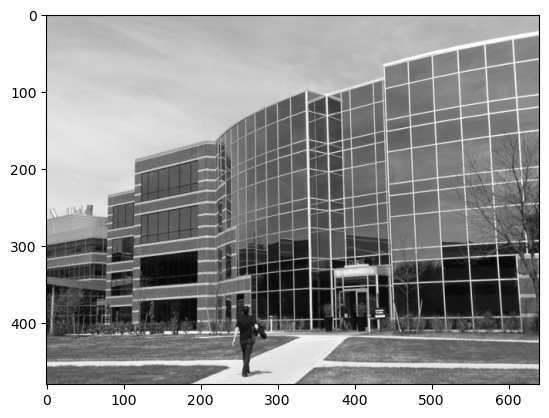

In [1]:
###################
# code given
import cv2                      # we use this mainly to read the files
import numpy as np              # the everpresent numpy
import matplotlib.pyplot as plt # does what it says on the tin - plotting

# Read in the image. We don't want to mess with colour, so we convert to grayscale.
# Let's also have a look at the image
img = cv2.imread('building1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')

## A simple scaling

We want to implement a simple scaling, as is described in Video Lecture 1.2

The transform for scaling is given by the matrix:
$$
\textbf{T} = \begin{bmatrix}
a & 0 \\
0 & b 
\end{bmatrix}
$$
and thus, to transform the points in the image, we use
$$
\begin{bmatrix} x' \\ y' \end{bmatrix} = 
\begin{bmatrix}
a & 0 \\
0 & b 
\end{bmatrix}  
\begin{bmatrix} x \\ y \end{bmatrix}
$$
where $(x, y)$ is the point in the original image, and $(x', y')$ is the transformed point.


<font color='blue'>

#### Task:
    
In Python code, implement the scaling defined by the equations above. For each pixel in the original image, we will apply the transform, and put the pixel value at the resulting position in the output image.
    
1. Create the transformation matrix
1. Create an empty (black) image where the new image will be stored (hint [`np.zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html))
1. Iterate over all the pixels in the image (e.g., as a nested pair of for loops)
1. Apply the transformation to each pixel location (i.e., to the vector $(x, y)$ representing the pixel location). Get the result $(x', y')$ vector
1. Check that the resulting location $(x', y')$ is within the bounds of the image. You will get an error if you try to write outside of the image boundary.
1. Copy the pixel value from the input image location $(x, y)$ to the (valid) output image location $(x', y')$ (interpolated).
1. Display the resulting image ([`plt.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html), as above)

    
Some hints:
* Images are stored in grids, and the index (coordinate $(x, y)$) of each grid is an integer value. However, after you transform the integer coordinate using $\textbf{T}$, there is no guarantee that the resulting coordinates $(x', y')$ will be integer values. 
* What do we do? This requires [**interpolation**](https://www.cambridgeincolour.com/tutorials/image-interpolation.htm), of which two popular methods are _bilinear_ and _bicubic_. However, for this task, we will just round our values to the nearest integer (which is, in fact, called _nearest neighbour_ interpolation).
* To do this, once you have transformed a point, I suggest to round to the nearest integer using [`np.rint()`](https://numpy.org/doc/stable/reference/generated/numpy.rint.html) and then cast to an `int` type using [`.astype(int)`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html)
    
</font>

<font color='blue'>

###### Question: Some of the image has disappeared. Why? [Hint](https://blogs.mathworks.com/steve/2006/04/28/spatial-transforms-forward-mapping/)

If the scaling factors for a and b are greater than 1, they will scale the transformed image outside the bounding area of the original image.

[[0.66666667 0.        ]
 [0.         1.        ]]


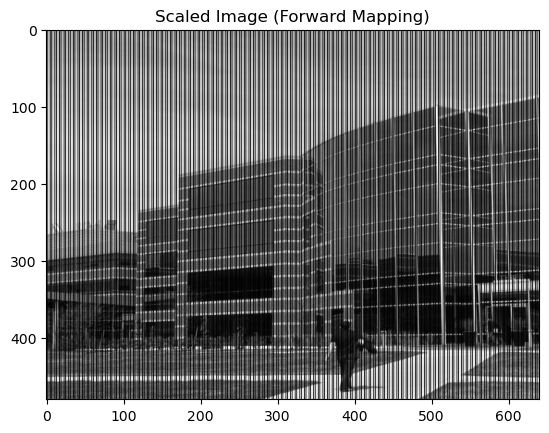

In [2]:
##################
# Your code here

#Create variables to store the scaling factors for the transformation matrix. These can be changed to experiment with different shapes and sizes of images.
a=1.5
b=1.0

# Create a new empty image of the size of the original
img_new = np.zeros(img.shape)

# Create the transform matrix
T = np.array([[a,0],
             [0,b]])  # Your code here: Create the appropriate matrix

#Create the inverse transform matrix
T_inv = (1/(a*b))*np.array([[b,0],
                  [0,a]])

# --- Image Transformation (Forward Mapping) ---

for y in range(img.shape[0]):  # iterate each row in the image
     for x in range(img.shape[1]):  # iterate each column
         pt = np.array([x,y])
         pt_new_float = T @ pt

        #perform rounding to nearest integer and casting to int type as recommended
         x_new = np.rint(pt_new_float[0]).astype(int)
         y_new = np.rint(pt_new_float[1]).astype(int)

         # check that the resulting point is within the image bounds
         if 0 <= y_new < img_new.shape[0] and 0 <= x_new < img_new.shape[1]:
             # Copy the pixel value from the original image to the new image
             img_new[y_new, x_new] = img[y, x]

 # Display the new image
plt.imshow(img_new, cmap='gray')
plt.title('Scaled Image (Forward Mapping)')
plt.show()

<font color='blue'>

###### Question: Make sure your matrix contains scaling factors greater than 1 (i.e., causing an upscaling). Why are there black pixels?

Do not have integer scaling in the x-direction. Some of the input pixels cannot be directly mapped to output pixels and some output pixels have more than one input pixel mapped to their location.

## Back-mapping the pixels

In the last task, we ended up with black pixels (vacant pixels) in the resulting image. Now we will address this using the method of back mapping, also call [inverse mapping](https://blogs.mathworks.com/steve/2006/05/05/spatial-transformations-inverse-mapping/).

Let's look at forward mapping first. Consider each input image pixel in turn. For each input image pixel:

Forward mapping:
1. Determine its location in input space, $(x, y)$.
1. Map that location to output space using $(x',y')^\top = \textbf{T}(x,y)^\top$.
1. Figure out which output pixel contains the location $(x',y')$. I.e., convert to integer values.
1. Copy the input pixel value to that output pixel.

This diagram illustrates the procedure:
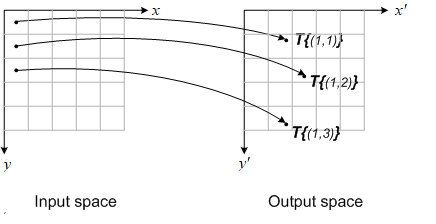


Forward mapping has two main disadvantages as a computational procedure: gaps and overlaps. Depending on specific spatial transform function, you may have some output pixels that did not receive any input image pixels; these are the gaps. You may also have some output pixels that received more than one input image pixel; these are the overlaps. In both cases, it is challenging to figure out a reasonable way to set those output pixels.

Because of the disadvantages of the forward mapping method, most of the practical implementations use a different technique, called back/inverse mapping.

Here's how it works:

Locate your output image pixel grid somewhere in output space. Then for each output pixel on the grid:

1. Apply the **inverse** spatial transformation to determine the corresponding location in input space: $(x,y)^\top = \textbf{T}^{-1}(x',y')^\top$.
1. Using the input image pixels nearest to $(x,y)$, *interpolate* to get an approximate value for the input image at $(x,y)$.
1. Use that value for the output pixel.

This diagram illustrates the procedure:
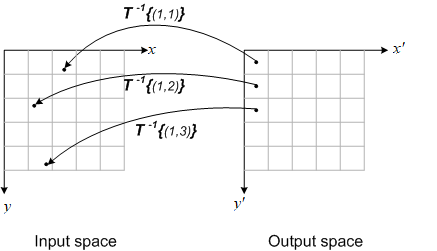

This method completely avoids problems with gaps and overlaps. You just have to decide which interpolation method to you (below, as above, we use the simplest nearest neighbour interpolation), and you also have to establish a rule for what value to use when $(x,y)$ isn't within the input image pixel grid.


<font color='blue'>

#### Task:
    
In Python code, implement the scaling using back mapping. For each pixel in the output image, we will apply the inverse transform, and copy the pixel value to the resulting position in the output image.
    
1. Create the transformation matrix
1. Invert the transformation ([`np.linalg.inv()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html))
1. Create an empty (black) image where the new image will be stored (hint [`np.zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html))
1. Iterate over all the pixels in the **output** image (e.g., as a nested pair of for loops)
1. Apply the inverse transformation to each output pixel location (i.e., to the vector $(x', y')$ representing the output pixel location). Get the result $(x, y)$ vector representing the input pixel location
1. Check that the resulting location $(x, y)$ is within the bounds of the input image. You will get an error if you try to read outside of the image boundary.
1. Copy the (valid) pixel value from the input image location $(x, y)$ (interpolated) to the output image location $(x', y')$.
1. Display the resulting image ([`plt.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html), as above)

As above, use nearest neighbour interpolation.
    
</font>

There were 0 attempts to read outside the original image boundary


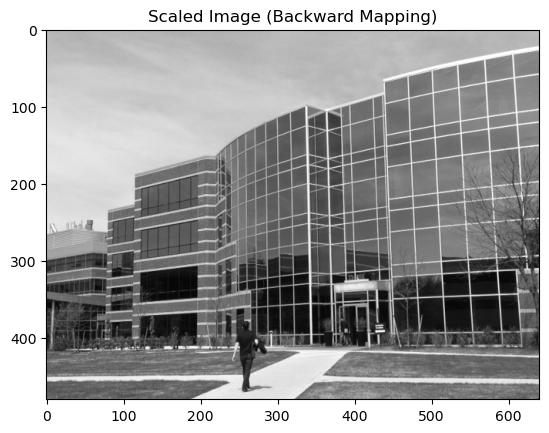

In [5]:
###############
# Your code here - make the code below work

# ----------- Scale Transform Backward Mapping --------------------#

# Scaling Factors
a=1.5
b=1.3

# Calculate the dimensions for the output space based on the scaling factors
img_hgt = int(img.shape[0] * b)
img_wdt = int(img.shape[1] * a)

# Create a new empty image of the calculated size for the output space
img_out = np.zeros((img_hgt, img_wdt))

# Create the transform matrix
T = np.array([[a,0],
             [0,b]])  

# Create the inverse transform matrix
T_inv = np.linalg.inv(T)         

bound_err_cnt_b=0 #Backward boundary error count - the number of attempts to write
                  # transformed points outside original image boundary

for y_t in range(img_out.shape[0]):  # iterate each row in the output image
    for x_t in range(img_out.shape[1]): # iterate each column
        pt_out = np.array([x_t,y_t]) # create a matrix of pixels contained in the output image
        pt_out_fl = T_inv @ pt_out # the transformed point might not be an integer, '_fl' denotes 'float'
                                   # '_out' denotes 'output space'

    # Perform rounding to nearest integer, '_r' denotes rounded
    # this also performs nearest neighbours interpolation
        x_r = np.rint(pt_out_fl[0])
        y_r = np.rint(pt_out_fl[1])

    # Now cast the rounded figure to the integer type
        x_out = x_r.astype(int)
        y_out = y_r.astype(int)

    # check that the resulting point is within the original input image bounds
        if 0 <= y_out < img.shape[0] and 0 <= x_out < img.shape[1]:
        # Copy the pixel value from the output space to the input space
            img[y, x]=img_out[y_t, x_t]
        else:
            bound_err_cnt_b += 1
print(f"There were {bound_err_cnt_b} attempts to read outside the original image boundary")

# Display the inverse transformed image
plt.imshow(img, cmap='gray')
plt.title('Scaled Image (Backward Mapping)')
plt.show()

<font color='blue'>

###### Question: Why does this fill the gaps?

Backward mapping maps through every single pixel in the output image. The inverse transform calculates where it came from in the original image. All pixels in the original image had an integer value before scaling. In this way, backward mapping is able to map every pixel to an original pixel.

<font color='blue'>

###### Question: We use the inverse of the scaling matrix above. To estimate this, we use the Numpy function. But how would we calculate it directly, for the scaling matrix? Or, to put it another way, what does the inverse of the scaling matrix look like?

To calculate it directly, we would swap the positions of a and b and multiply the matrix by the inverse of the determinant, ab. 

## More transforms

### Shear and Rotation

You now have a template for applying arbitrary 2D transforms to an image, using back-mapping.

Recall, the shearing transform is given by
$$
\textbf{T}_s = \begin{bmatrix}
1 & a \\
b & 1 
\end{bmatrix}
$$
Where $a$ and $b$ are the shearing parameters, in this case. Rotation is given by
$$
\textbf{T}_r = \begin{bmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta) 
\end{bmatrix}
$$
Where $\theta$ is the rotation angle. Rotation matrices are typically also denoted $\textbf{R}$.

<font color='blue'>

#### Task:

In two separate cells, transform the the image using:
 * Shear
 * Rotation
    
You can feel free to copy down and adapt your code from above.

There were 123181 attempts to write outside the original image boundary


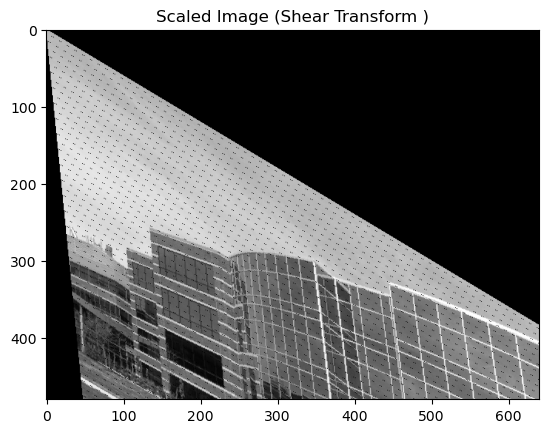

In [8]:
##################
# Your code here


#-----------------Shear Transform---------------------------#


# Create variables to store the scaling factors for the transformation matrix.
# These can be changed to experiment with different shapes and sizes of images.
a=0.1
b=0.6

# Create a new empty image of the size of the original
img_new = np.zeros(img.shape)
#print(img_new)


# Create the transform matrix
T_s = np.array([[1,a],
             [b,1]])  # Your code here: Create the appropriate matrix


# --- Image Transformation 

bound_err_cnt_sh=0 #Shear boundary error count - the number of attempts to write
                  # transformed points outside original image boundary

for y in range(img.shape[0]):  # iterate each row in the image
     for x in range(img.shape[1]):  # iterate each column
         pt = np.array([x,y])
         pt_t_fl = T_s @ pt # the transformed point might not be an integer, '_fl' denotes 'float'
                          # '_t' denotes 'transformed'

        # Perform rounding to nearest integer
        # This also performs nearest neighbours interpolation 
         x_r = np.rint(pt_t_fl[0])
         y_r = np.rint(pt_t_fl[1])

         # Now cast the rounded figure to the integer type
         x_t = x_r.astype(int)
         y_t = y_r.astype(int)

         # check that the transformed point is within the image bounds of the
         # original image
         if 0 <= y_t < img.shape[0] and 0 <= x_t < img.shape[1]:
             # Copy the pixel value from the original image to the new image
             img_new[y_t, x_t] = img[y, x]
         else:
            bound_err_cnt_sh += 1
print(f"There were {bound_err_cnt_sh} attempts to write outside the original image boundary")

 # Display the new image
plt.imshow(img_new, cmap='gray')
plt.title('Scaled Image (Shear Transform )')
plt.show()

There were 26776 attempts to write outside the original image boundary


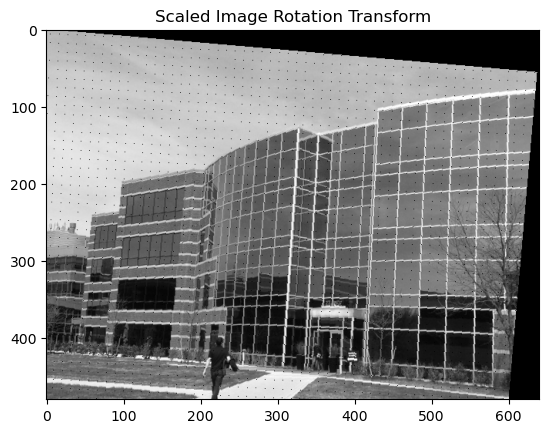

In [9]:
##################
# Your code here 

#--------------Rotation Transform------------------------------#


# Create a new empty image of the size of the original
img_new = np.zeros(img.shape)

#Angle of rotation
angle_in_degrees = 5

# Calculate angle in radians
theta = np.radians(angle_in_degrees) # Convert degrees to radians if needed

# Create the Rotation Matrix
T_r= np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

# --- Image Transformation (Rotation) ---

bound_err_cnt_r=0 #Rotation boundary error count - the number of attempts to write
                  # transformed points outside original image boundary

for y in range(img.shape[0]):  # iterate each row in the image
     for x in range(img.shape[1]):  # iterate each column
         pt = np.array([x,y])
         pt_t_fl = T_r @ pt # the transformed point might not be an integer, '_fl' denotes 'float'
                          # '_t' denotes 'transformed'

        # Perform rounding to nearest integer
        # This also performs nearest neighbours interpolation 
         x_r = np.rint(pt_t_fl[0])
         y_r = np.rint(pt_t_fl[1])

         # Now cast the rounded figure to the integer type
         x_t = x_r.astype(int)
         y_t = y_r.astype(int)

         # check that the transformed point is within the image bounds of the
         # original image
         if 0 <= y_t < img.shape[0] and 0 <= x_t < img.shape[1]:
             # Copy the pixel value from the original image to the new image
             img_new[y_t, x_t] = img[y, x]
         else:
            bound_err_cnt_r += 1
print(f"There were {bound_err_cnt_r} attempts to write outside the original image boundary")

 # Display the new image
plt.imshow(img_new, cmap='gray')
plt.title('Scaled Image Rotation Transform')
plt.show()

<font color='blue'>

###### Question: why does the rotation "rotate" in a clockwise manner with positive angles?

The matplotlib function, matplotlib.pyplot.imshow(), displays the origin (0,0) at the top-left corner of the image, unlike in classical mathematics where it is displayed at the bottom left. This means that the positive direction of the y-axis is downwards. A positive angle is then made by rotating an image clockwise

## Combining 2D transformations

The 2D transformations can be combined together, through matrix multiplication. Say we have two different transforms, $\textbf{T}_1$ and $\textbf{T}_2$. We have an image, that we wish to transform by $\textbf{T}_2$ first, and then $\textbf{T}_1$. Well, instead of doing two matrix multiplications on every point in the image, we can combine the transformations into a single matrix through matrix multiplication ($\textbf{T} = \textbf{T}_1\textbf{T}_2$, where $\textbf{T}$ is the overall matrix representation of the two transformations), and thus apply the two transforms using a single matrix multiplication.

<font color='blue'>
    
#### Task: 

Combine the shear and rotation transformation by defining each matrix separately, and then multiplying them together.
    
In one code cell, apply it as $\textbf{T} = \textbf{T}_s\textbf{T}_r$
    
In another code cell, apply it as $\textbf{T} = \textbf{T}_r\textbf{T}_s$ (inverting the order of multiplication of the matrices)

There were 104822 attempts to write outside the original image boundary


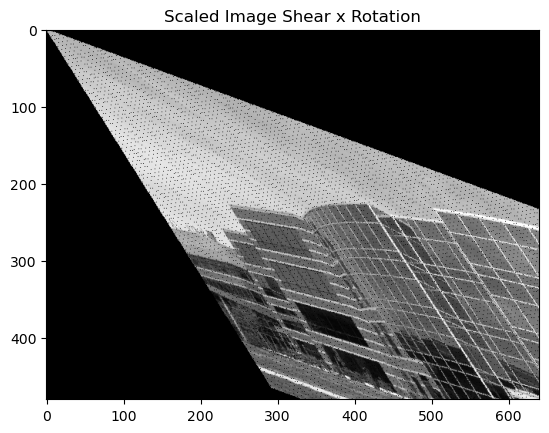

In [12]:
##################
# Your code here 

# The following code implements the first matrix multiplication - Ts.Tr

# Define Shear Transform Matrix

# Scale Factors
a=0.7
b=0.3
# Create the Matrix
T_s = np.array([[1,a],
             [b,1]])

#Define Rotation Transform Matrix
#Angle of rotation
angle_in_degrees = 5

# Calculate angle in radians
theta = np.radians(angle_in_degrees) # Convert degrees to radians if needed

# Create the Rotation Matrix
T_r= np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

# Create a new empty image of the size of the original
img_new = np.zeros(img.shape)

# --- Image Transformation (Rotation) ---

bound_err_cnt=0 #Boundary error count - the number of attempts to write
                  # transformed points outside original image boundary

for y in range(img.shape[0]):  # iterate each row in the image
     for x in range(img.shape[1]):  # iterate each column
         pt = np.array([x,y])
         pt_t_fl = T_s @ T_r @ pt #Multiplication of shear x rotation x pixel

        # Perform rounding to nearest integer
        # This also performs nearest neighbours interpolation 
         x_r = np.rint(pt_t_fl[0])
         y_r = np.rint(pt_t_fl[1])

         # Now cast the rounded figure to the integer type
         x_t = x_r.astype(int)
         y_t = y_r.astype(int)

         # check that the transformed point is within the image bounds of the
         # original image
         if 0 <= y_t < img.shape[0] and 0 <= x_t < img.shape[1]:
             # Copy the pixel value from the original image to the new image
             img_new[y_t, x_t] = img[y, x]
         else:
            bound_err_cnt += 1
print(f"There were {bound_err_cnt} attempts to write outside the original image boundary")

 # Display the new image
plt.imshow(img_new, cmap='gray')
plt.title('Scaled Image Shear x Rotation')
plt.show()

There were 105799 attempts to write outside the original image boundary


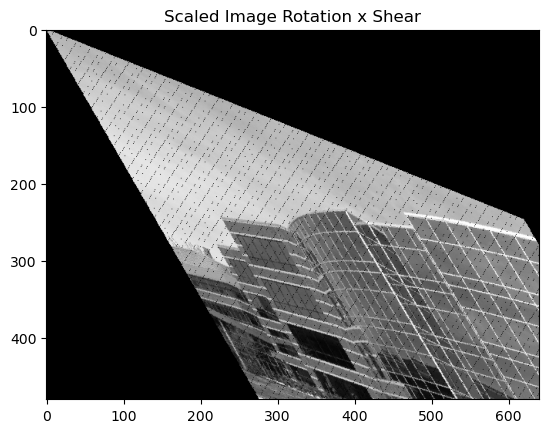

In [13]:
##################
# Your code here 

# The following code implements the second matrix multiplication - Tr.Ts

# Define Shear Transform Matrix

# Scale Factors
a=0.7
b=0.3
# Create the Matrix
T_s = np.array([[1,a],
             [b,1]])

#Define Rotation Transform Matrix
#Angle of rotation
angle_in_degrees = 5

# Calculate angle in radians
theta = np.radians(angle_in_degrees) # Convert degrees to radians if needed

# Create the Rotation Matrix
T_r= np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])

# Create a new empty image of the size of the original
img_new = np.zeros(img.shape)

# --- Image Transformation (Rotation) ---

bound_err_cnt=0 #Boundary error count - the number of attempts to write
                  # transformed points outside original image boundary

for y in range(img.shape[0]):  # iterate each row in the image
     for x in range(img.shape[1]):  # iterate each column
         pt = np.array([x,y])
         pt_t_fl = T_r @ T_s @ pt #Multiplication of rotation x shear x pixel

        # Perform rounding to nearest integer
        # This also performs nearest neighbours interpolation 
         x_r = np.rint(pt_t_fl[0])
         y_r = np.rint(pt_t_fl[1])

         # Now cast the rounded figure to the integer type
         x_t = x_r.astype(int)
         y_t = y_r.astype(int)

         # check that the transformed point is within the image bounds of the
         # original image
         if 0 <= y_t < img.shape[0] and 0 <= x_t < img.shape[1]:
             # Copy the pixel value from the original image to the new image
             img_new[y_t, x_t] = img[y, x]
         else:
            bound_err_cnt += 1
print(f"There were {bound_err_cnt} attempts to write outside the original image boundary")

 # Display the new image
plt.imshow(img_new, cmap='gray')
plt.title('Scaled Image Rotation x Shear')
plt.show()

<font color='blue'>

###### Question: When the two transforms are applied in different order, the result is different. Why is this?

Unlike scalar multiplication, matrix multiplication is not commutative

# Extra Credit

Some extra credit if you complete the following task. I will give you extra marks to compesnate for any failings in the other tasks in this e-tivity (if any).

<font color='blue'>
    
#### Task:

Take one of the transforms above, and do an implementation where you expland the size of the image to account for pixels that are outside the resulting image in the original implementation. You only need to account for the extra pixels in the positive axis dimensions. That is, if a pixel is transformed to a point with negative dimension values, you can still ignore this.
    
**Hint**: You can figure out the resulting image dimensions by forward transforming the four corners of the image.

In [ ]:
##################
# Your code here 